# Save and Restore Models in TensorFlow 2.0

#### Author: Ivan Bongiorni, Data Scientist at GfK.

[LinkedIn profile](https://www.linkedin.com/in/ivan-bongiorni-b8a583164/), personal email: ivanbongiorni@gmail.com

Summary:

1. Load data + quick dataprep,
2. Model architecture,
3. Save the model afte training,
4. Restore the model and keep training.

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
print(tf.__version__)

from matplotlib import pyplot as plt

2.0.0-alpha0


## 1. Load data + dataprep

The spam classification dataset, [available from the UCI ML repository](https://archive.ics.uci.edu/ml/datasets/spambase), contains an already preprocessed collection of email data. Each datapoint corresponds to an email, and is classified as either "spam" or "not spam".

In [2]:
# load dataframe
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data", header=None)
df.shape

(4601, 58)

In [3]:
# one-hot encode target variable
classification = pd.get_dummies(df.iloc[:,57])

df = df.drop(df.columns[57], axis=1)   # drop target col from explanatory df

df = df.values.astype(np.float64)
classification = classification.values.astype(np.float64)

In [4]:
## TRAIN-TEST SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, classification, test_size=0.25, random_state=173)

print('X_train shape: ' + str(X_train.shape) + '\ny_train shape: ' + str(y_train.shape))
print('\nX_test shape: ' + str(X_test.shape) + '\ny_test shape: ' + str(y_test.shape))


# SCALE DATA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train shape: (3450, 57)
y_train shape: (3450, 2)

X_test shape: (1151, 57)
y_test shape: (1151, 2)


## 2. Model architecture

In [5]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import elu, softmax

# Architecture
n_input = X_train.shape[1]
n_hidden1 = 30
n_hidden2 = 30
n_hidden3 = 15
n_output = y_train.shape[1]

# set dropout probability
dropout_prob = 0.1



model = tf.keras.models.Sequential([
    Dense(n_input, input_shape = (n_input,), activation = elu),   # Input layer
    
    Dense(n_hidden1, activation = elu), # hidden layer 1
    Dropout(dropout_prob), 
    
    Dense(n_hidden2, activation = elu), # hidden layer 2
    Dropout(dropout_prob), 
    
    Dense(n_hidden3, activation = elu), # hidden layer 3
    Dropout(dropout_prob), 
    
    Dense(n_output, activation = softmax)  # Output layer
])

# set number of epochs
n_epochs = 500

# Loss: Binary cross-entropy 
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Binary Accuracy
accuracy = tf.keras.metrics.BinaryAccuracy()

# Adam Optimizer
optimizer = tf.optimizers.Adam(learning_rate = 0.001)

To train the Network, I will use the wrapper function from [the first Notebook](https://github.com/IvanBongiorni/TensorFlow2.0_Tutorial/blob/master/TensorFlow2.0_01_basic_Classifier.ipynb):

In [6]:

def train_model(model, train, target, loss, optimizer, metrics, n_epochs, verbose=True, plot=True):
    '''
    Trains a TensorFlow 2.0 model
    
    Returns:
        prediction: The model's prediction - numpy
        loss_history: list
        metrics_history: list
    
    Arguments:
        model: a Sequential() model
        train: Train dataset (numpy)
        target: Target dataset - True outcome (numpy)
        loss: loss object or function
        optimizer: optimizer object (learnin rate is specified within)
        metrics: an evaluation metrics of the model's goodness
        n_epochs: number of iterations of training
        verbose: print training progress yes/no
        plot = plot loss and accuracy histories at the end of training y/n
    '''
    import numpy as np
    import tensorflow as tf
    import matplotlib.pyplot as plt
    
    
    loss_history = []
    metrics_history = []
    
    for epoch in range(n_epochs):
    
        with tf.GradientTape() as tape:
            current_loss = loss(model(train), target)
        
        gradients = tape.gradient(current_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        loss_history.append(current_loss.numpy())
        metrics.update_state(target, model(train))
        current_metrics = metrics.result().numpy()
        metrics_history.append(current_metrics)
        
        if verbose:            
            if (epoch+1) % 100 == 0:
                print(str(epoch+1) 
                      + '.\tTraining Loss: ' + str(current_loss.numpy()) 
                      + ',\tAccuracy: ' + str(current_metrics))
    
        accuracy.reset_states()
    
    print('\nTraining complete.')
    
    prediction = model(X_train)
    
    if plot:
        plt.figure(figsize = (15, 4))
        plt.subplots_adjust(wspace=0.2)  # this distances the plots

        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Loss History')
        plt.xlabel('epochs')
        plt.ylabel('Binary Cross-Entropy')

        plt.subplot(1, 2, 2)
        plt.plot(metrics_history)
        plt.title('Metrics History')
        plt.xlabel('epochs')
        plt.ylabel('Metrics')
        
        plt.show()
    
    return loss_history, metrics_history

And call it:

100.	Training Loss: 1.08087158203125,	Accuracy: 0.9356522
200.	Training Loss: 0.8725841641426086,	Accuracy: 0.9472464
300.	Training Loss: 0.7593502402305603,	Accuracy: 0.95246375
400.	Training Loss: 0.7209241986274719,	Accuracy: 0.9542029
500.	Training Loss: 0.7009227275848389,	Accuracy: 0.95507246

Training complete.


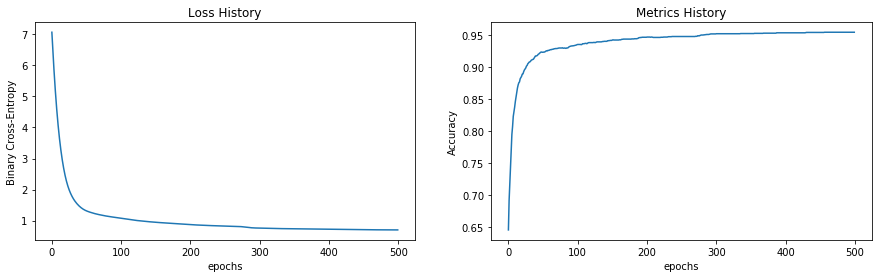

In [7]:
loss_history, accuracy_history = train_model(model, X_train, y_train, 
                                             bce_loss, optimizer, accuracy, n_epochs)

## 3. Save the model after training

In TensorFlow 2.0 it's as simple as that:

In [13]:
# just specify model's name and directory
tf.saved_model.save(model, 'home/ ... /path/to/folder')

At this point, you'll find a saved_model.pb object in the directory your speficied. That file contains your Neural Network, with its architecture and its trained weights.

## 4. Restore the model and keep training

Let's say you have time to train your model a little more. Let's restore it and continue to train it.

In [9]:
# you just need 'load' from the same directory you wrote above
restored_model = tf.saved_model.load('home/ ... /path/to/folder')

At this point, we can keep training our model for other 500 epochs:

100.	Training Loss: 0.6489710807800293,	Accuracy: 0.9582609
200.	Training Loss: 0.6375355124473572,	Accuracy: 0.9588406
300.	Training Loss: 0.6364323496818542,	Accuracy: 0.9588406
400.	Training Loss: 0.6316857933998108,	Accuracy: 0.9591304
500.	Training Loss: 0.6307226419448853,	Accuracy: 0.9591304

Training complete.


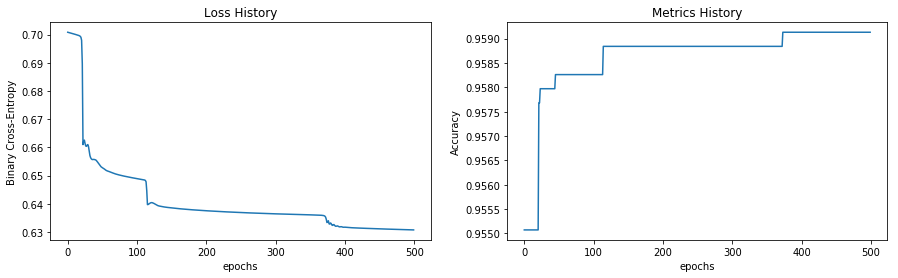

In [10]:
loss_history, accuracy_history = train_model(model, X_train, y_train, 
                                             bce_loss, optimizer, accuracy, n_epochs)

As you can see, the loss and accuracy scores are a continuation from previous training. Training a model in multiple sessions by saving and restoring it when needed can be vital for very heavy models.